<a href="https://colab.research.google.com/github/prajwal-u2/advanced-machine-learning/blob/main/Neural_Network_Protein_Engineering/Neural_Network_Protein_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment consists of 2 sections and each section has multiple exercises (4 exercises in total with one optional exercise).

**Assignment Due: November 14th, 2025, 11:59 PM CST.**

**Grace Period (No penalty): 2 days till 16th November, 2025, 11:59 PM CST.**

**No submission will be accepted after 16th November.**

# I. Implement Backpropagation for attention layer [25 points]

The goal of this exercise is to manually implement the backward pass for the scaled dot-product attention layer.

**Background: forward pass of Attention**

Here are details of the attention layer forward pass for completeness. Please see the class slides or references for more details if interested.

We start with three matrices derived from our input set of tokens: **Query (Q)**, **Key (K)**, and **Value (V)**.

The attention mechanism works in four steps, which translate directly to following matrix operations:

1.  **Compute scores:** We measure the similarity between each Query and every Key using a dot product.
    `Scores = Q @ K.T`

2.  **Scale scores:** To prevent the dot product values from becoming too large, we scale them by the square root of the dimension of the keys (`d_k`).
    `Scaled_Scores = Scores / sqrt(d_k)`

3.  **Compute attention weights (A):** We apply a softmax function to the scaled scores. This converts them into a probability distribution, where each row sums to 1. These weights, `A`, determine how much attention each Query pays to each Key.

    `A = softmax(Scaled_Scores)`

4.  **Compute output:** We compute the output by taking a weighted sum of all the Value vectors, using our calculated attention weights.
    `Output = A @ V`

This `Output` is a new set of vectors, where each vector is a contextualized representation of an input element.


#### **PyTorch context: manual vs. automatic differentiation**

PyTorch core aspect is its automatic differentiation engine, `autograd`. When we call `loss.backward()`, PyTorch automatically traces the computations backward and calculates the gradients for all parameters.

In this exercise, you will *manually* implement the function that performs this backward calculation for the attention layer. We will then verify your manual implementation by comparing its results directly with what PyTorch's `autograd` computes.

#### **Exercise 1: implementing the backward pass**

Your task is to implement the `attention_backward` function. The function receives the "upstream" gradient `d_output`, which is the derivative of the final loss (`L`) with respect to the `Output` of our attention layer (`dL/dOutput`).

Using this gradient and the chain rule, you have to compute the gradients with respect to the layer's inputs: `dQ` (`dL/dQ`), `dK` (`dL/dK`), and `dV` (`dL/dV`).

Please find the python code below. Please fill in the missing parts of the `attention_backward` function. The forward pass and the checker code are also provided.

In [ ]:
import torch
import torch.nn.functional as F
import math
def attention_forward(Q, K, V):
    """
    forward pass for a scaled dot-product attention layer.

    Args:
        Q (torch.Tensor): Query tensor, shape (N, T, d_k)
        K (torch.Tensor): Key tensor, shape (N, T, d_k)
        V (torch.Tensor): Value tensor, shape (N, T, d_v)

        N = batch size
        T = number of tokens (set size or sequence length)
        d_k = dimension of keys/queries
        d_v = dimension of values

    Returns:
        tuple: A tuple containing:
            - output (torch.Tensor): shape (N, T, d_v)
            - cache (dict): A dictionary storing intermediate tensors for backprop.
    """
    d_k = Q.shape[-1]

    # step 1 & 2: compute and scale scores
    # (N, T, d_k) @ (N, d_k, T) -> (N, T, T)
    scaled_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k))

    # step 3: compute attention weights
    # using the name alpha instead of A for easily parsing of the code
    alpha = F.softmax(scaled_scores, dim=-1)

    # step 4: compute context vector
    # (N, T, T) @ (N, T, d_v) -> (N, T, d_v)
    output = torch.matmul(alpha, V)

    cache = {
        "Q": Q, "K": K, "V": V,
        "alpha": alpha, "d_k": d_k
    }

    return output, cache

In [ ]:
def attention_backward(d_output, cache):
    """
    backward pass for a scaled dot-product attention layer.

    Args:
        d_output (torch.Tensor): upstream gradient of the loss with respect to the output.
                                 Shape (N, T, d_v).
        cache (dict): a dictionary storing intermediate tensors from the forward pass.

    Returns:
        tuple: A tuple containing the gradients with respect to Q, K, and V:
            - dQ (torch.Tensor): Gradient w.r.t. Q, shape (N, T, d_k)
            - dK (torch.Tensor): Gradient w.r.t. K, shape (N, T, d_k)
            - dV (torch.Tensor): Gradient w.r.t. V, shape (N, T, d_v)
    """
    # Unpack tensors from cache
    Q = cache["Q"]
    K = cache["K"]
    V = cache["V"]
    alpha = cache["alpha"]
    d_k = cache["d_k"]

    # --- Your required implementation starts here ---

    # We will compute the gradients by reversing the forward pass steps.
    # The chain rule tells us how to propagate the `d_output` gradient
    # backwards through each operation.

    # Let L be the final loss. d_output is dL/dOutput.

    # Step 1: Backpropagate through `Output = alpha @ V`
    # We need to find dL/dalpha and dL/dV.
    # Using the rules for matrix multiplication gradients:
    # If C = A @ B, then dL/dA = dL/dC @ B.T and dL/dB = A.T @ dL/dC.

    # TO-DO: Calculate dV, the gradient w.r.t. V.
    dV = torch.matmul(alpha.transpose(-2, -1), d_output)

    # TO-DO: Calculate d_alpha, the gradient w.r.t. alpha.
    d_alpha = torch.matmul(d_output, V.transpose(-2, -1))

    # Step 2: Backpropagate through `alpha = softmax(scaled_scores)`
    # This is the trickiest step. The derivative of softmax is a bit more involved.
    # For a vector s = softmax(z), the gradient dL/dz is given by:
    # dL/dz_i = s_i * (dL/ds_i - sum_j(dL/ds_j * s_j))
    # In our case, s is alpha, z is scaled_scores, and dL/ds is d_alpha.

    # TO-DO: Calculate d_scaled_scores, the gradient w.r.t. scaled_scores.
    # Hint: The sum is over the last dimension.
    d_scaled_scores = alpha * (d_alpha - torch.sum(d_alpha * alpha, dim=-1, keepdim=True))

    # Step 3: Backpropagate through scaled_scores = scores / sqrt(d_k)
    # This is a simple element-wise division.
    # If y = x / c, then dL/dx = dL/dy / c.

    # TO-DO: Calculate d_scores, the gradient w.r.t. scores.
    d_scores = d_scaled_scores / torch.sqrt(torch.tensor(d_k))

    # Step 4: Backpropagate through scores = Q @ K.T
    # We use the matrix multiplication rule again to find dL/dQ and dL/dK.
    # Remember that K was transposed in the forward pass.
    # dL/dQ = dL/dscores @ K
    # dL/dK.T = Q.T @ dL/dscores  => dL/dK = (dL/dscores.T @ Q).T = Q.T @ dL/dscores

    # TO-DO: Calculate dQ, the gradient w.r.t. Q.
    dQ = torch.matmul(d_scores, K)

    # TO-DO: Calculate dK, the gradient w.r.t. K.
    # dK = torch.matmul(Q.transpose(-2, -1), d_scores)
    dK = torch.matmul(d_scores.transpose(-2, -1), Q)
    # Hint: Be careful with transposes.

    return dQ, dK, dV

### **gradient checker**

We will evaluate the implementation by comparing the gradients you computed manually with the gradients computed by PyTorch's `autograd`. If they match, your implementation is correct.

In [ ]:
# set up problem dimensions and a random seed for reproducibility
N, T, d_k, d_v = 2, 5, 8, 10
torch.manual_seed(42)

# initialize random input tensors (using float64 for higher precision in gradient checking)
Q = torch.randn(N, T, d_k, dtype=torch.float64)
K = torch.randn(N, T, d_k, dtype=torch.float64)
V = torch.randn(N, T, d_v, dtype=torch.float64)

Q_auto, K_auto, V_auto = Q.clone(), K.clone(), V.clone()
Q_auto.requires_grad_()
K_auto.requires_grad_()
V_auto.requires_grad_()

output_auto, _ = attention_forward(Q_auto, K_auto, V_auto)

# define a dummy loss and an upstream gradient
# The sum of all elements in the output serves as a simple loss.
# d_output = torch.ones_like(output_auto)
d_output = torch.randn_like(output_auto)


output_auto.backward(gradient=d_output)

# --- manual implementation ---

# peform forward pass to get the cache for your manual backward pass
# we can use the original tensors (Q, K, V) which don't track gradients
output_manual, cache = attention_forward(Q, K, V)

# perform manual backward pass
dQ_manual, dK_manual, dV_manual = attention_backward(d_output, cache)


# Use torch.allclose for robust floating-point comparison
is_dQ_correct = torch.allclose(Q_auto.grad, dQ_manual, atol=1e-6)
is_dK_correct = torch.allclose(K_auto.grad, dK_manual, atol=1e-6)
is_dV_correct = torch.allclose(V_auto.grad, dV_manual, atol=1e-6)

print(f"Gradient for Q is correct: {is_dQ_correct}")
print(f"Gradient for K is correct: {is_dK_correct}")
print(f"Gradient for V is correct: {is_dV_correct}")

if not all([is_dQ_correct, is_dK_correct, is_dV_correct]):
    print("\nOne or more gradients are incorrect. Please check your implementation.")
    # Optional: Print the gradients to see the differences
    # print("Autograd dQ:\n", Q_auto.grad)
    # print("Manual dQ:\n", dQ_manual)

Gradient for Q is correct: True
Gradient for K is correct: True
Gradient for V is correct: True


# II. Implement Transformer for protein engineering problem [75 points]

**Motivation and problem background:** Proteins perform most tasks in living cells. Engineering new proteins has large range of applications from developing new therapeutics to vaccines to creating enzymes for sustainable manufacturing. Each protein can be represented as a sequence of amino acids and a big challenge in protein engineering is navigating the vast "sequence space" of proteins to find variants with desired properties.

This exercise is based from a **real world dataset** derived from a protein engineering problem in [Engineering highly active nuclease enzymes with machine learning and high-throughput screening](https://www.biorxiv.org/content/10.1101/2024.03.21.585615v1). The specific type of protein here is enzyme (called NuCB). NucB naturally helps disperse biofilms. Biofilms are slimy, surface-attached communities of bacteria held together partly by extracellular DNA. They can form on tissues (e.g., chronic wounds) and medical devices, making infections hard to treat. Using NucB to degrade the DNA scaffold can weaken the biofilm so antibiotics and immune defenses work better.

(Additional references:
[Cool video about enzymes](https://www.ted.com/talks/adam_garske_how_designing_brand_new_enzymes_could_change_the_world), [2018 Nobel prize about protein engineering](https://www.nobelprize.org/prizes/chemistry/2018/press-release))

## Machine learning perspective

In this assignment you will build and analzye a transformer based classifier that predicts activity labels from protein sequence. *This is a supervised machine learning task (concretely multi-class classification) where the input is a sequence of integers (corresponding to protein sequence) and the output is a label denoting the activity level of the protein.*

We provide you with preprocessed data with training/valid/test splits. [Dataset Download Link](https://drive.google.com/file/d/1NQIKNnqYOkmoNfcvIn-o3mPjrga0cemC/view?usp=sharing). The dataset contains protein sequences and their corresponding activity levels, categorized into four classes. The data is split chronologically: the first three rounds of experiments (G1-G3) form the training and validation sets, and the final, fourth round (G4) serves as the test set. This dataset is **very** expensive to generate since the authors conducted wet-lab experiments and also represents a true real world scenario of how we would like to use machine learning for new discovery.


**Do not use test data split for training your model in any way. Test split should only be used for checking the model's performance at the end. Use validation split for model selection or hyperparameter selection. You will be graded zero for this exercise if you use test split in training the model.**

In [ ]:
# Download the dataset from Google Drive using the provided URL
!gdown --id 1NQIKNnqYOkmoNfcvIn-o3mPjrga0cemC -O /content/nuclease_design_processed.pkl

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NQIKNnqYOkmoNfcvIn-o3mPjrga0cemC
From (redirected): https://drive.google.com/uc?id=1NQIKNnqYOkmoNfcvIn-o3mPjrga0cemC&confirm=t&uuid=577d679e-bd1a-4be4-81d9-8e96c7b5cadf
To: /content/nuclease_design_processed.pkl
100% 1.11G/1.11G [00:09<00:00, 121MB/s]


In [ ]:
import pickle
import numpy as np

# Load the data
with open('/content/nuclease_design_processed.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
data.keys()

dict_keys(['X_train_strings', 'X_val_strings', 'X_test_strings', 'X_train_int', 'X_val_int', 'X_test_int', 'X_train_onehot', 'X_val_onehot', 'X_test_onehot', 'X_train_flat', 'X_val_flat', 'X_test_flat', 'y_train', 'y_val', 'y_test', 'train_metadata', 'val_metadata', 'test_metadata', 'label_encoder', 'activity_levels', 'label_mapping', 'aa_to_int', 'int_to_aa', 'amino_acids', 'sequence_length', 'vocab_size', 'num_classes', 'variable_region_start', 'split_info'])

In [ ]:
print(data['X_train_onehot'].shape)
print(data['X_val_onehot'].shape)
print(data['X_test_onehot'].shape)
print(data['y_train'].shape, data['y_val'].shape, data['y_test'].shape)

(32284, 118, 20)
(8072, 118, 20)
(15404, 118, 20)
(32284,) (8072,) (15404,)


## Input data format


The input data is available in **4 different formats**. Default recommended version: `Integer version`. You are also feel free to pick the one that works best for your model:

| Format | Shape |
|--------|-------|
| **Integer** | `(n_samples, 118)` |
| **One-hot** | `(n_samples, 118, 20)` |
| **Flattened** | `(n_samples, 2360)` |
| **Strings** | `(n_samples,)` |

*   **Integer Encoded (`_int`):** Sequences are represented as arrays of integers.
    *   `X_train = data['X_train_int']` Shape: `(num_samples, 118)`
*   **One-Hot Encoded (`_onehot`):** Each amino acid is represented by a 20-dimensional binary vector (one hot encodin of the integer).
    *   `X_train = data['X_train_onehot']` Shape: `(num_samples, 118, 20)`
*   **Flattened One-Hot (`_flat`):** The one-hot encoded sequences are flattened into a single vector. Suitable for traditional ML models like Random Forest or SVM.
    *   `X_train = data['X_train_flat']` Shape: `(num_samples, 118 * 20)`
*   **String Sequences (`_strings`):** The raw amino acid sequences. Useful for custom feature engineering.
    *   `X_train = data['X_train_strings']` Array of strings.


In [ ]:
print(data['X_train_strings'][0])
print(data['X_train_int'][0])
print(data['X_train_onehot'][0])

YSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHPQVCTLERSGAEKRREESLQGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ
[18 15 14  6  8  0  5  7  0  0  1 18  3  3 19 10 18 13 14  0 15  1 18 14
  5 16  7  0  8  9 15  3  0  9 11  0  7  8 14  6 19  4 16 10  5  1 15  7
  0  5 11  1  1  5  5 15 10  6  7  9 14 16 11 14  7 13  3  1  3  5 17 14
 12  0 12  4  5  5  7  7 11  7  0 15 19  1 18 19 15 15 15  3  2  1  7  0
  7 15 17 19  7  2  1 10  2  7 18  0  3  7 16  1  9 10 13  9 19  6]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


## Output data/labels format and mappings


*   **Labels (`y_`):** The target variables are integer-encoded class labels from 0 to 3.
    *   `y_train = data['y_train']`
*   **Label Mapping:** A dictionary to interpret the integer labels.
    *   `label_mapping = data['label_mapping']`
    *   `{0: 'non-functional', 1: 'activity > 0', 2: 'activity > WT', 3: 'activity > A73R'}`
    *   The classes are ordinal: activity increases from class 0 to 3.
*   **Amino Acid Vocabulary:** Dictionaries for converting between amino acids and integers.
    *   `aa_to_int = data['aa_to_int']`
    *   `int_to_aa = data['int_to_aa']`


There are **4 class labels (corresponding to activity levels)** (ordered from lowest to highest):
- **Class 0**: `non-functional` - No detectable activity
- **Class 1**: `activity_greater_than_0` - Some activity, less than wild-type (wild-type is a starting protein)
- **Class 2**: `activity_greater_than_WT` - Better than wild-type
- **Class 3**: `activity_greater_than_A73R` - Better than the best known protein



In [ ]:
print(data['y_train'][:5])
print(data['y_val'][:5])
print(data['y_test'][:5])

[2 0 0 0 0]
[0 0 2 0 0]
[1 0 0 0 0]


### Recommended: Similar to assignment 1, we recommend carefully visualizing and understanding the data before getting started. It will be good to use Pytorch datasets and dataloaders for batch processing. It is recommend to log data and config values properly. Learning how to use an experiment management platform like [WandB](https://docs.wandb.ai/models/tutorials) will be time-saving in the long run.

## Exercise 2. Implement a Transformer neural network for sequence classification.

High-level sketch:

Input -> Input Representation -> [Transformer Block] x N -> Classification Head -> Output

**1. Input representation**
```
Input (Integer Sequence)
Shape: (B, L)
     |
     v
nn.Embedding
     |
     v
Embedded Sequence
Shape: (B, L, E)
     |
     v
Add (+) Positional Encoding
     |
     v
Final Input Representation
Shape: (B, L, E)
```

**2. Transformer Block (Repeated N times)**



```
Input Features from Previous Layer
Shape: (B, L, E)
     |
     v
+-----------------------------+
|    Multi-Head Attention     |  <-- Sub-layer 1
+-----------------------------+
     |
     v
Residual Connection & Normalization layer
     |
     v
+---------------------------------------+
|    Token-wise Feedforward Network     |  <-- Sub-layer 2
+---------------------------------------+
     |
     v
Residual Connection & Normalization layer
     |
     v
Output Features for Next Layer
Shape: (B, L, E)
```

**3. Classification Head**

```
Final Contextualized Features from last Transformer Block
Shape: (B, L, E)
     |
     v
Global Average Pooling
     |
     v
Sequence Representation
Shape: (B, E)
     |
     v
nn.Linear
     |
     v
Output (Logits)
Shape: (B, NumClasses)
```

## Exercise 3. Training, evaluation and visualization.

Instantiate the loss function (nn.CrossEntropyLoss) and optimizer (torch.optim.Adam with a learning rate of 1e-4). Train the transformer (with 2 transformer blocks) for 10 epochs (each epoch is one pass through the entire dataset).

3.1). Visualize the training by plotting loss curves (x-axis: number of training steps (one train step is one batch update), y-axis:  plot two lines one for training loss per batch and one for validation loss).

3.2). Print classification metrics on the three splits (training, valid, test):
- Classification Accuracy
- Precision/Recall
- F1 Score
- Confusion matrix

**Unlike assignment 1, you have to implement and show the visualization plots this time for assignment 2. The grading will be on correct implementation of the model, visualization of loss curves, and final performance of the model.**

## Exercise 4. Hyperparameter Tuning

Train the Transformer architecture with two different optimizers (1 epoch):
- Adam (torch.optim.Adam) with learning rates 1e-2, 1e-3, and 1e-4.
- SGD with momentum (torch.optim.SGD, momentum=0.9) with learning rates 1e-2, 1e-3, and 1e-4.

Plot the validation loss curves for all six training runs on a single graph. Create a bar chart comparing the final test accuracy of the six models.

## Optional Exercise 5: Please read instructions carefully

This exercise 5 is completely optional. Skipping Exercise 5 will not reduce your grade on this assignment. If you do really well on this exercise, you can earn 100 extra points applied to assigment 3 i.e., assignment 3 will be waived for you. You must still complete Exercises 1–4. Do not work only on Exercise 5. Tackle Exercise 5 after finishing the required exercises for this assignment.

---
You may notice that recall (per-class accuracy) for the high-activity class ("label 3") is very low. It is expected since this is a hard real-world problem and improving recall/precision for label 3 directly corresponds to discovering useful proteins in the real world.  

Concretely, your goal is to build a model that, when asked to propose the top k most promising candidates, packs that list with as many true high-activity variants as possible. You have a fixed experimental budget to test k=100 new candidates (nuclease variants) from the test set. Your model will rank all variants in the test set by their predicted probability of belonging to the highest activity class (class 3). You will then "send" the top 100 candidates to the lab for testing.

**Goal:** Maximize the Precision@100 for the highest activity class (class 3: 'activity > A73R').

Precision@k: This metric answers the question: "Of the top k candidates I selected, what fraction were actually successful?"
First, use your model to get the predicted probabilities for class 3 for all samples in the test set.
Second, select the 100 samples with the highest predicted probability for class 3.
Precision@100 = (Number of true class 3 samples in your top 100) / 100

You are free to use any data transformation/augmentation, architecture/model improvement or better optimization strategies to work on this exercise. The only rule is **not** use test data during training in any form (no test leakage).

# EDA
Explore and visualize the provided protein sequence dataset to understand its structure, content, and characteristics, focusing on data exploration and visualization techniques

## Inspect the data structure




In [ ]:
print(data.keys())
print(data['X_train_onehot'].shape)
print(data['X_val_onehot'].shape)
print(data['X_test_onehot'].shape)
print(data['y_train'].shape)
print(data['y_val'].shape)
print(data['y_test'].shape)

dict_keys(['X_train_strings', 'X_val_strings', 'X_test_strings', 'X_train_int', 'X_val_int', 'X_test_int', 'X_train_onehot', 'X_val_onehot', 'X_test_onehot', 'X_train_flat', 'X_val_flat', 'X_test_flat', 'y_train', 'y_val', 'y_test', 'train_metadata', 'val_metadata', 'test_metadata', 'label_encoder', 'activity_levels', 'label_mapping', 'aa_to_int', 'int_to_aa', 'amino_acids', 'sequence_length', 'vocab_size', 'num_classes', 'variable_region_start', 'split_info'])
(32284, 118, 20)
(8072, 118, 20)
(15404, 118, 20)
(32284,)
(8072,)
(15404,)


## Analyze Input Data

In [ ]:
# Display the first few integer-encoded training sequences
print("First 5 integer-encoded training sequences:")
print(data['X_train_int'][:5])

# Display the first few training labels
print("\nFirst 5 training labels:")
print(data['y_train'][:5])

# Display the shape of the training data and labels
print("\nShape of training data (X_train_int):", data['X_train_int'].shape)
print("Shape of training labels (y_train):", data['y_train'].shape)

First 5 integer-encoded training sequences:
[[18 15 14  6  8  0  5  7  0  0  1 18  3  3 19 10 18 13 14  0 15  1 18 14
   5 16  7  0  8  9 15  3  0  9 11  0  7  8 14  6 19  4 16 10  5  1 15  7
   0  5 11  1  1  5  5 15 10  6  7  9 14 16 11 14  7 13  3  1  3  5 17 14
  12  0 12  4  5  5  7  7 11  7  0 15 19  1 18 19 15 15 15  3  2  1  7  0
   7 15 17 19  7  2  1 10  2  7 18  0  3  7 16  1  9 10 13  9 19  6]
 [18 15 14  6  8  0  5  7  0  0  1 18  3  3 19 10 18 13 14  0 15  1 18 14
   7 16  7  0  8  9 15  3  0  9 11  0  7  8  0  3 19  4 16  9  5  1 15  7
   0  3 11  1  1 16  5 15 10 11  7  9 14 16 11 14  7 13  3  1  3  5 17 14
  12  0 12  4  5  5  7  7 11  7 19 15 19  1 18 19 15 15 15  3  2  1  7  0
   7 15 17 19  7  2  1 10  2  7 18  0  3  7 16  1  9 10 13  9 19  6]
 [18 15 14  6  8  0  5  7  0  0  1 18  3  3 19 10 18 13 14  0 15  1 18 14
   5  9 17  0  8 19 15  3  0  9 11  0  0  5  0  3 19  4 16  9  5  1 15  7
   0  3 11  1  1  6  5 15 10 11  7  9 14 16 11 14  7 13  3  1  3  5 17 14
  12

## Analyze label distribution



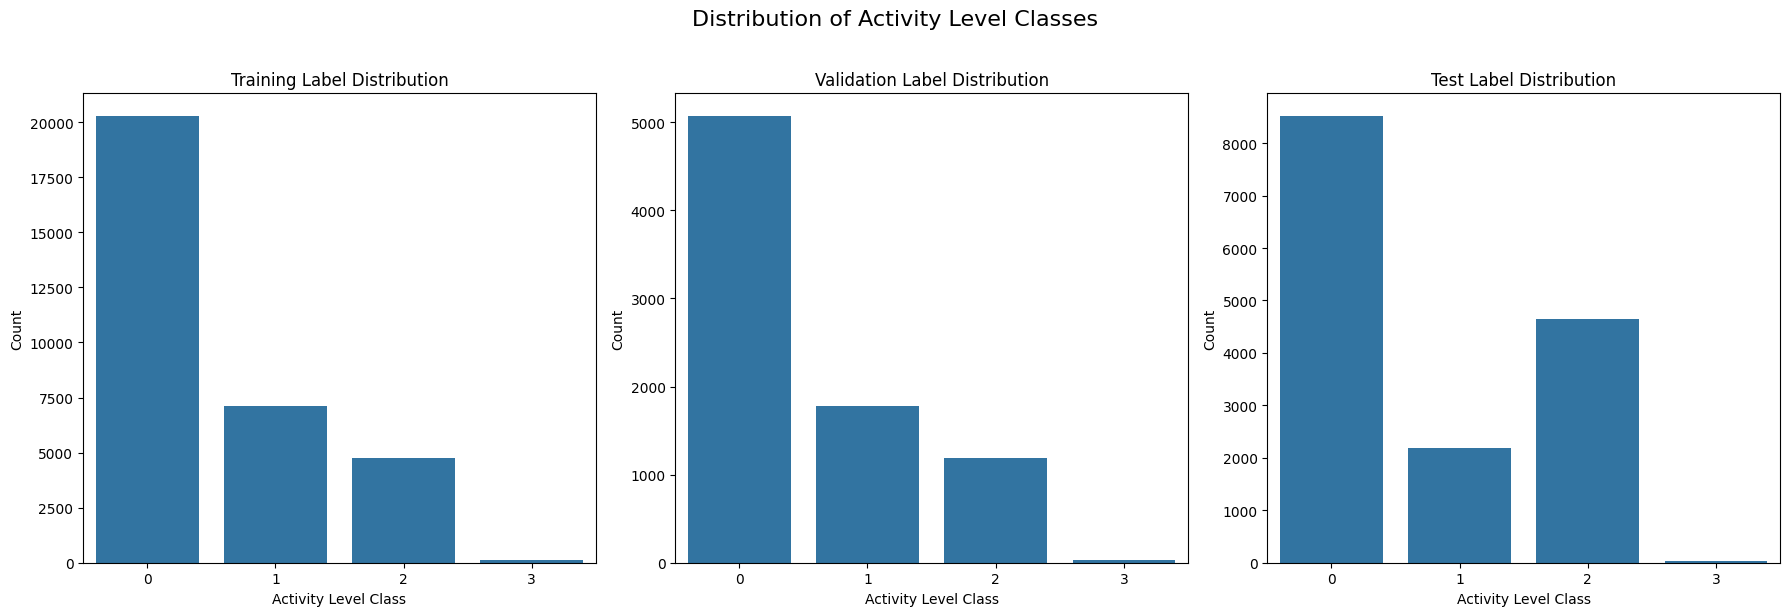

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x=pd.Series(data['y_train']), ax=axes[0])
axes[0].set_title('Training Label Distribution')
axes[0].set_xlabel('Activity Level Class')
axes[0].set_ylabel('Count')


sns.countplot(x=pd.Series(data['y_val']), ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Activity Level Class')
axes[1].set_ylabel('Count')


sns.countplot(x=pd.Series(data['y_test']), ax=axes[2])
axes[2].set_title('Test Label Distribution')
axes[2].set_xlabel('Activity Level Class')
axes[2].set_ylabel('Count')

plt.suptitle('Distribution of Activity Level Classes', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## Investigate amino acid distribution


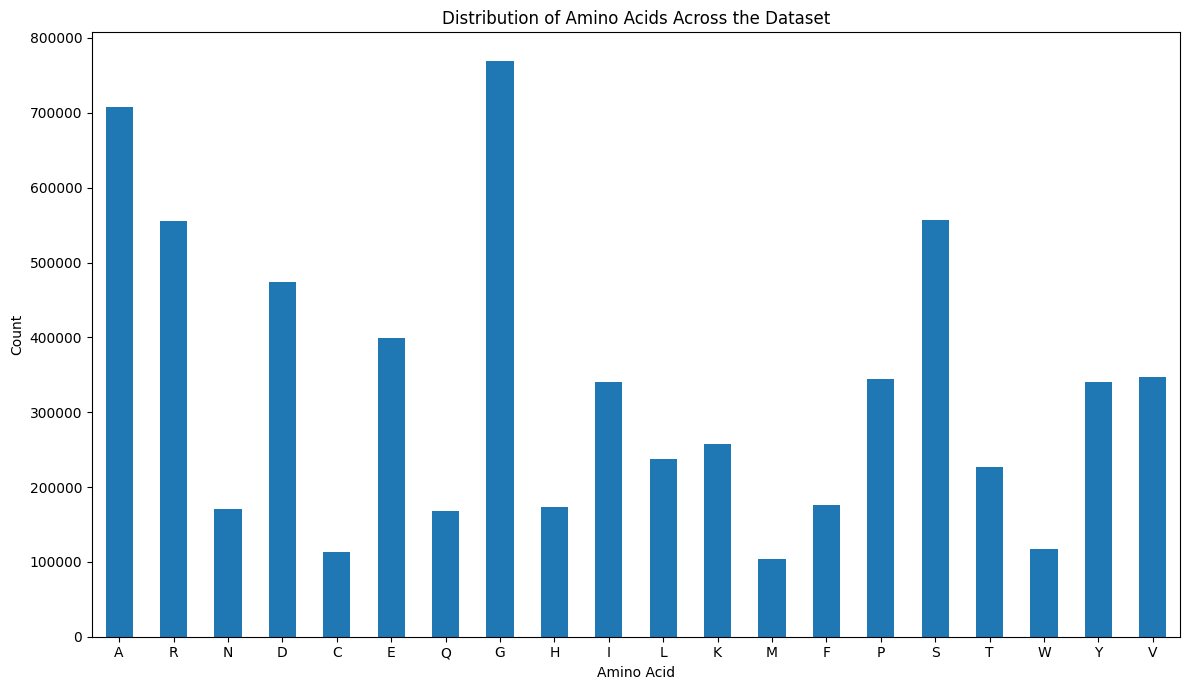

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

all_sequences_int = np.concatenate([data['X_train_int'], data['X_val_int'], data['X_test_int']])
amino_acid_counts = np.bincount(all_sequences_int.flatten())

int_to_aa = data['int_to_aa']
full_counts = np.zeros(data['vocab_size'], dtype=int)
full_counts[:len(amino_acid_counts)] = amino_acid_counts

amino_acid_labels = [int_to_aa[i] for i in range(data['vocab_size'])]

counts_series = pd.Series(full_counts, index=amino_acid_labels)

plt.figure(figsize=(12, 7))
counts_series.plot(kind='bar')

plt.xlabel('Amino Acid')
plt.ylabel('Count')
plt.title('Distribution of Amino Acids Across the Dataset')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Logistic Regression Baseline Model


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

X_tr = data['X_train_flat']; y_tr = data['y_train']
X_va = data['X_val_flat'];   y_va = data['y_val']

clf = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_va)

acc  = accuracy_score(y_va, y_pred)
mf1  = f1_score(y_va, y_pred, average='macro')

print(f"Validation — Accuracy: {acc:.4f} | Macro-F1: {mf1:.4f}\n")
print(classification_report(
    y_va, y_pred, digits=4,
    target_names=[data['label_mapping'][i] for i in range(int(data['num_classes']))]
))
print("Confusion matrix (validation):")
print(confusion_matrix(y_va, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation — Accuracy: 0.7021 | Macro-F1: 0.4852

                            precision    recall  f1-score   support

            non-functional     0.9525    0.7907    0.8641      5074
   activity_greater_than_0     0.5376    0.5889    0.5621      1783
  activity_greater_than_WT     0.4475    0.5000    0.4723      1184
activity_greater_than_A73R     0.0223    0.4194    0.0423        31

                  accuracy                         0.7021      8072
                 macro avg     0.4900    0.5747    0.4852      8072
              weighted avg     0.7832    0.7021    0.7368      8072

Confusion matrix (validation):
[[4012  614  303  145]
 [ 174 1050  411  148]
 [  26  288  592  278]
 [   0    1   17   13]]


In [ ]:
# Test set results for baseline logistic regression model

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support

X_te = data['X_test_flat']
y_te = data['y_test']

y_pred_test = clf.predict(X_te)

acc_test  = accuracy_score(y_te, y_pred_test)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_te, y_pred_test, average='weighted', zero_division=0)
f1_macro  = f1_score(y_te, y_pred_test, average='macro')
f1_micro = f1_score(y_te, y_pred_test, average='micro')
cm_test = confusion_matrix(y_te, y_pred_test)
report_test = classification_report(
    y_te, y_pred_test, digits=4,
    target_names=[data['label_mapping'][i] for i in range(int(data['num_classes']))]
)

print(f"=== TEST METRICS (Logistic Regression) ===")
print(f"Accuracy: {acc_test:.4f}")
print(f"Precision (weighted): {prec_w:.4f}")
print(f"Recall (weighted):    {rec_w:.4f}")
print(f"F1-score (weighted):  {f1_w:.4f}")
print(f"F1-score (macro):     {f1_macro:.4f}")
print(f"F1-score (micro):     {f1_micro:.4f}\n")

print("Confusion matrix (test):")
print(cm_test)

print("\nPer-class report:")
print(report_test)

=== TEST METRICS (Logistic Regression) ===
Accuracy: 0.4962
Precision (weighted): 0.6956
Recall (weighted):    0.4962
F1-score (weighted):  0.5565
F1-score (macro):     0.3782
F1-score (micro):     0.4962

Confusion matrix (test):
[[4169 1261 2077 1016]
 [ 205  961  715  303]
 [ 149  901 2500 1105]
 [   1    8   20   13]]

Per-class report:
                            precision    recall  f1-score   support

            non-functional     0.9215    0.4891    0.6391      8523
   activity_greater_than_0     0.3069    0.4400    0.3616      2184
  activity_greater_than_WT     0.4706    0.5371    0.5017      4655
activity_greater_than_A73R     0.0053    0.3095    0.0105        42

                  accuracy                         0.4962     15404
                 macro avg     0.4261    0.4439    0.3782     15404
              weighted avg     0.6956    0.4962    0.5565     15404



# Transformer Neural Network

## Import and Setup

In [ ]:
import os, random, json
import numpy as np
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import wandb
from collections import Counter

## Dataset


In [ ]:
# Load the data
!gdown --id 1NQIKNnqYOkmoNfcvIn-o3mPjrga0cemC -O /content/nuclease_design_processed.pkl

with open('/content/nuclease_design_processed.pkl', 'rb') as f:
    data = pickle.load(f)

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NQIKNnqYOkmoNfcvIn-o3mPjrga0cemC
From (redirected): https://drive.google.com/uc?id=1NQIKNnqYOkmoNfcvIn-o3mPjrga0cemC&confirm=t&uuid=72bc878e-54a8-40a3-9615-a5a69506cd8b
To: /content/nuclease_design_processed.pkl
100% 1.11G/1.11G [00:08<00:00, 126MB/s]


# Exercise 2


## Model Setup


In [ ]:
# Transformer neural network model setup
import torch
import torch.nn as nn

class ProteinTransformerSimple(nn.Module):

    def __init__(self, vocab_size: int, seq_len: int, num_classes: int,
                 d_model: int = 256, n_layers: int = 2, n_heads: int = 4,
                 d_ff: int = 1024, dropout: float = 0.1, activation: str = "gelu"):
        super().__init__()
        self.seq_len = seq_len

        # Input and positional encoding
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb   = nn.Embedding(seq_len,    d_model)

        # Transformer block with Multi-Head Attention, Feed Forward Network with residual connections and normalization
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # Classification
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)

        # initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight);
                if m.bias is not None: nn.init.zeros_(m.bias)
            if isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:

        B, L = input_ids.shape
        assert L == self.seq_len, f"Expected length {self.seq_len}, got {L}"

        pos = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)

        # encoding
        x = self.token_emb(input_ids) + self.pos_emb(pos)
        z = self.encoder(x)

        # Pooling
        z_pool = z.mean(dim=1)
        logits = self.classifier(self.dropout(z_pool))
        return logits


# Exercise 3

## Training and loss visualization

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: umesh006 (ml-projects-umn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 01 | last train loss 0.9941 | val_loss 1.1053
Saved best model to ex3_transformer_best_45epochs_2e-4lr_4layers.pt
Logged best model artifact for epoch 1
Epoch 02 | last train loss 0.9404 | val_loss 0.8694
Saved best model to ex3_transformer_best_45epochs_2e-4lr_4layers.pt
Logged best model artifact for epoch 2
Epoch 03 | last train loss 0.6814 | val_loss 0.8038
Saved best model to ex3_transformer_best_45epochs_2e-4lr_4layers.pt
Logged best model artifact for epoch 3
Epoch 04 | last train loss 0.6257 | val_loss 0.7075
Saved best model to ex3_transformer_best_45epochs_2e-4lr_4layers.pt
Logged best model artifact for epoch 4
Epoch 05 | last train loss 0.5599 | val_loss 0.6861
Saved best model to ex3_transformer_best_45epochs_2e-4lr_4layers.pt
Logged best model artifact for epoch 5
Epoch 06 | last train loss 0.5483 | val_loss 0.6390
Saved best model to ex3_transformer_best_45epochs_2e-4lr_4layers.pt
Logged best model artifact for epoch 6
Epoch 07 | last train loss 0.7535 | val_loss 0

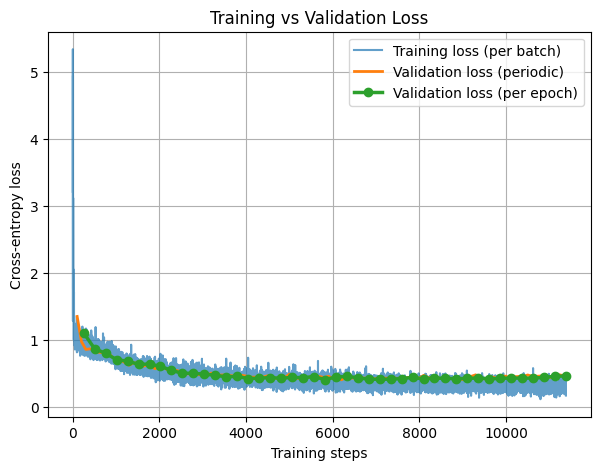

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss_step,▇█▇▆▆▅▆▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▂▂▃▃▂▃▂▃▃▃▃▂▂▁▂▂▁▂
val_loss_epoch,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss_step,█▆▆▆▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
epoch,45
train_loss_step,0.17276
val_loss_epoch,0.46261
val_loss_step,0.47371


In [ ]:
# Exercise 3.1: Train and visualize loss curves
import torch, numpy as np, random, matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import wandb

# Set seed and device
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

# set Data loaders
BATCH_SIZE = 128
X_train = torch.tensor(data["X_train_int"], dtype=torch.long)
y_train = torch.tensor(data["y_train"],     dtype=torch.long)
X_val   = torch.tensor(data["X_val_int"],   dtype=torch.long)
y_val   = torch.tensor(data["y_val"],       dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Instantiate model for training from above
model = ProteinTransformerSimple(
    vocab_size=int(data["vocab_size"]),
    seq_len=int(data["sequence_length"]),
    num_classes=int(data["num_classes"]),
    d_model=256,
    n_layers=4,
    n_heads=4,
    d_ff=1024,
    dropout=0.1
).to(device)

# Set loss and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

EPOCHS = 45
train_losses = []
val_losses_step, val_steps = [], []
val_loss_per_epoch, epoch_marks = [], []
global_step = 0

# Initialize a wandb run
run = wandb.init(project="protein-transformer", group="Exercise3_45Epochs_2e-4LR_4Layers", config={ # Updated group name to reflect 4 layers
    "epochs": EPOCHS,
    "learning_rate": 2e-4,
    "batch_size": BATCH_SIZE,
    "d_model": 256,
    "n_layers": 4,
    "n_heads": 4,
    "d_ff": 1024,
    "dropout": 0.1,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss"
})

# Log model gradients to wandb
wandb.watch(model, log="gradients", log_freq=100)

best_val_loss = float('inf')
best_model_path = "ex3_transformer_best_45epochs_2e-4lr_4layers.pt"
final_model_path = "ex3_transformer_final_45epochs_2e-4lr_4layers.pt"

for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        global_step += 1

        # Log training loss to wandb
        wandb.log({"train_loss_step": loss.item()}, step=global_step)

        # periodic validation loss for the curve
        if global_step % 100 == 0:
            model.eval()
            with torch.no_grad():
                vloss_sum = 0.0; vcount = 0
                for xv, yv in val_loader:
                    xv, yv = xv.to(device), yv.to(device)
                    vout = model(xv)
                    vloss_sum += criterion(vout, yv).item() * xv.size(0)
                    vcount += xv.size(0)
            val_loss_periodic = vloss_sum / vcount
            val_losses_step.append(val_loss_periodic)
            val_steps.append(global_step)

            # Log periodic validation loss to wandb
            wandb.log({"val_loss_step": val_loss_periodic}, step=global_step)

            model.train()

    # end-of-epoch validation point for visualization
    model.eval()
    with torch.no_grad():
        vloss_sum = 0.0; vcount = 0
        for xv, yv in val_loader:
            xv, yv = xv.to(device), yv.to(device)
            vout = model(xv)
            vloss_sum += criterion(vout, yv).item() * xv.size(0)
            vcount += xv.size(0)
    vloss_epoch = vloss_sum / vcount
    val_loss_per_epoch.append(vloss_epoch)
    epoch_marks.append(global_step)
    print(f"Epoch {ep:02d} | last train loss {train_losses[-1]:.4f} | val_loss {vloss_epoch:.4f}")

    # Log end-of-epoch validation loss to wandb
    wandb.log({"val_loss_epoch": vloss_epoch, "epoch": ep}, step=global_step)

    # Save best model based on validation loss
    if vloss_epoch < best_val_loss:
        best_val_loss = vloss_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model to {best_model_path}")
        # Log best model as artifact
        if wandb.run is not None:
            artifact = wandb.Artifact(f"best_transformer_45epochs_2e-4lr_4layers", type="model") # Updated artifact name
            artifact.add_file(best_model_path)
            wandb.log_artifact(artifact)
            print(f"Logged best model artifact for epoch {ep}")

# Save final model
torch.save(model.state_dict(), final_model_path)
print(f"Saved final model to {final_model_path}")
# Log final model as artifact
if wandb.run is not None:
    artifact = wandb.Artifact("final_transformer_45epochs_2e-4lr_4layers", type="model") # Updated artifact name
    artifact.add_file(final_model_path)
    wandb.log_artifact(artifact)
    print(f"Logged final model artifact")


# Plot loss curves
plt.figure(figsize=(7,5))
plt.plot(range(len(train_losses)), train_losses, label="Training loss (per batch)", alpha=0.7)
if val_losses_step:
    plt.plot(val_steps, val_losses_step, label="Validation loss (periodic)", linewidth=2)
plt.plot(epoch_marks, val_loss_per_epoch, label="Validation loss (per epoch)", linewidth=2.5, marker='o')
plt.xlabel("Training steps"); plt.ylabel("Cross-entropy loss")
plt.title("Training vs Validation Loss"); plt.grid(True); plt.legend(); plt.show()

wandb_run_id = None
# Finish wandb run
if wandb.run is not None:
    wandb_run_id = wandb.run.id
    wandb.finish()

## Evaluation and metrics

In [ ]:
# Exercise 3.2: Evaluation on train/valid/test with required metrics
import torch, numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score # Import f1_score directly
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set model
model = ProteinTransformerSimple(
    vocab_size=int(data["vocab_size"]),
    seq_len=int(data["sequence_length"]),
    num_classes=int(data["num_classes"]),
    d_model=256, n_layers=4, n_heads=4, d_ff=1024, dropout=0.1
).to(device)

# Load the final model saved from the previous training run
best_model_path = "ex3_transformer_final_45epochs_2e-4lr_4layers.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

BATCH_SIZE = 128
X_train = torch.tensor(data["X_train_int"], dtype=torch.long)
y_train = torch.tensor(data["y_train"],     dtype=torch.long)
X_val   = torch.tensor(data["X_val_int"],   dtype=torch.long)
y_val   = torch.tensor(data["y_val"],       dtype=torch.long)
X_test  = torch.tensor(data["X_test_int"],  dtype=torch.long)
y_test  = torch.tensor(data["y_test"],      dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
val_loader   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

@torch.no_grad()
def eval_split(loader):
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        ys.append(yb)
        ps.append(logits.argmax(dim=-1).cpu())
    y_true = torch.cat(ys).numpy()
    y_pred = torch.cat(ps).numpy()
    acc = accuracy_score(y_true, y_pred)
    # Calculate weighted, macro, and micro F1 scores
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(
        y_true, y_pred, digits=4,
        target_names=[data['label_mapping'][i] for i in range(int(data['num_classes']))]
    )
    return acc, prec_w, rec_w, f1_w, f1_macro, f1_micro, cm, report, y_true, y_pred

# Resuming the previous wandb run for saving the metrics in the same run
previous_run_id = wandb_run_id

try:
    eval_run = wandb.init(
        project="protein-transformer",
        group="Exercise3_45Epochs_2e-4LR",
        id=previous_run_id,
        resume="must"
    )
    print(f"Resuming wandb run with ID: {previous_run_id}")
except Exception as e:
    print(f"Could not resume run {previous_run_id}: {e}")
    print("Initializing a new run instead.")
    eval_run = wandb.init(
        project="protein-transformer",
        group="Exercise3_45Epochs_2e-4LR",
        job_type="evaluation",
        config={
            "model_path": best_model_path,
            "batch_size": BATCH_SIZE
        }
    )


for name, loader in [("TRAIN", train_loader), ("VALID", val_loader), ("TEST", test_loader)]:
    acc, prec_w, rec_w, f1_w, f1_macro, f1_micro, cm, report, y_true, y_pred = eval_split(loader)
    print(f"\n=== {name} METRICS ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (weighted): {prec_w:.4f}")
    print(f"Recall (weighted):    {rec_w:.4f}")
    print(f"F1-score (weighted):  {f1_w:.4f}")
    print(f"F1-score (macro):     {f1_macro:.4f}")
    print(f"F1-score (micro):     {f1_micro:.4f}")
    print("Confusion matrix:")
    print(cm)
    print("\nPer-class report:")
    print(report)

    # Log metrics to wandb
    if eval_run is not None:
        # Log confusion matrix
        class_names = [data['label_mapping'][i] for i in range(int(data['num_classes']))]
        cm_table = wandb.Table(data=cm, columns=class_names)
        eval_run.log({
            f"{name}_accuracy": acc,
            f"{name}_precision_weighted": prec_w,
            f"{name}_recall_weighted": rec_w,
            f"{name}_f1_weighted": f1_w,
            f"{name}_f1_macro": f1_macro,
            f"{name}_f1_micro": f1_micro,
            f"{name}_confusion_matrix": cm_table,
            f"{name}_classification_report": report
        })

# Finish the wandb run
if 'eval_run' in locals() and eval_run is not wandb.run:
    eval_run.finish()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Resuming wandb run with ID: 589p6sw7

=== TRAIN METRICS ===
Accuracy: 0.8908
Precision (weighted): 0.8873
Recall (weighted):    0.8908
F1-score (weighted):  0.8868
F1-score (macro):     0.7104
F1-score (micro):     0.8908
Confusion matrix:
[[19774   361   158     0]
 [ 1636  5036   460     0]
 [  100   700  3927     6]
 [    0     1   102    23]]

Per-class report:
                            precision    recall  f1-score   support

            non-functional     0.9193    0.9744    0.9461     20293
   activity_greater_than_0     0.8258    0.7061    0.7613      7132
  activity_greater_than_WT     0.8451    0.8297    0.8373      4733
activity_greater_than_A73R     0.7931    0.1825    0.2968       126

                  accuracy                         0.8908     32284
                 macro avg     0.8458    0.6732    0.7104     32284
              weighted avg     0.8873    0.8908    0.8868     32284


=== VALID METRICS ===
Accuracy: 0.8356
Precision (weighted): 0.8262
Recall (weighted

## Best model loaded from wandb for test set evaluation

Below are screenshots showing some of the models trained with different parameters. The model that achieved the best validation loss during training, specifically at epoch 23, was identified as the best model. While the model trained for the full 45 epochs showed some overfitting, the best performing model from epoch 23 was loaded from wandb for the final test set evaluation.

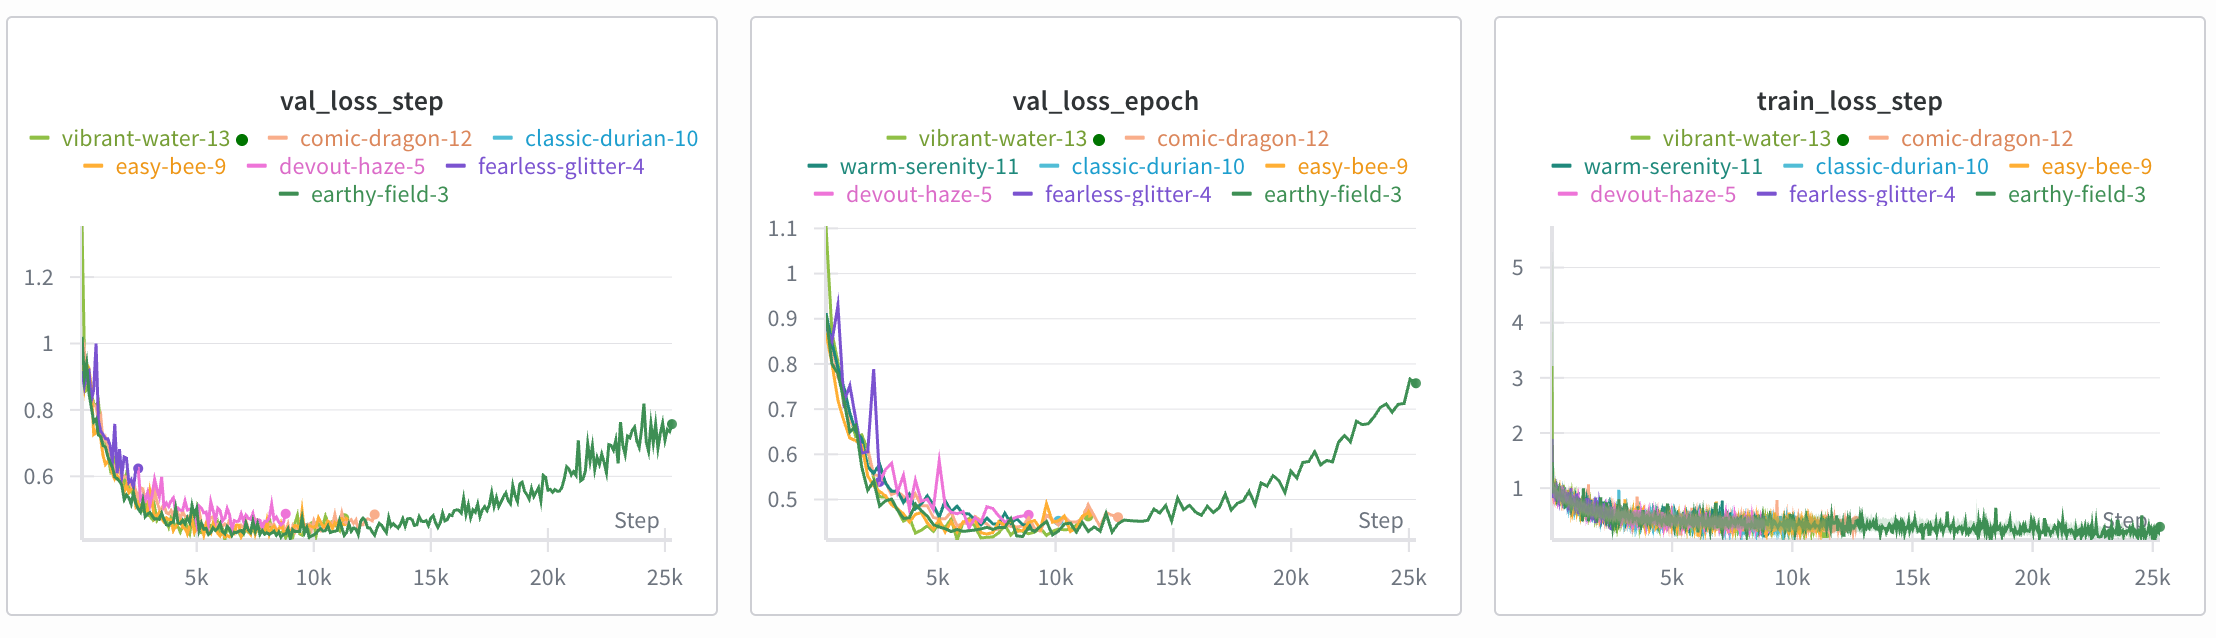

In [ ]:
import torch
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score # Import f1_score directly
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize wandb and download the artifact
if wandb.run is None:
    eval_run = wandb.init(project="protein-transformer", job_type="test-evaluation")
else:
    eval_run = wandb.run

# Downloading specific artifact from wandb
artifact_path = 'ml-projects-umn/protein-transformer/best_transformer_45epochs_2e-4lr_4layers:v14' # Use the specified artifact path
artifact = eval_run.use_artifact(artifact_path, type='model')
artifact_dir = artifact.download()

# Instantiate the model and load from the downloaded artifact
model = ProteinTransformerSimple(
    vocab_size=int(data["vocab_size"]),
    seq_len=int(data["sequence_length"]),
    num_classes=int(data["num_classes"]),
    d_model=256,
    n_layers=4,
    n_heads=4,
    d_ff=1024,
    dropout=0.1
).to(device)

# Find the .pt file within the downloaded artifact directory
model_path_in_artifact = None
for root, _, files in os.walk(artifact_dir):
    for file in files:
        if file.endswith('.pt'):
            model_path_in_artifact = os.path.join(root, file)
            break
    if model_path_in_artifact:
        break

if model_path_in_artifact and os.path.exists(model_path_in_artifact):
    model.load_state_dict(torch.load(model_path_in_artifact, map_location=device))
    model.eval()

    # Prepare the test data loader
    BATCH_SIZE = 128
    X_test  = torch.tensor(data["X_test_int"],  dtype=torch.long)
    y_test  = torch.tensor(data["y_test"],      dtype=torch.long)
    test_loader  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


    acc, prec_w, rec_w, f1_w, f1_macro, f1_micro, cm, report, _, _ = eval_split(test_loader)

    # Evaluate on Test Set
    print(f"\n=== TEST METRICS (Loaded from Artifact) ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (weighted): {prec_w:.4f}")
    print(f"Recall (weighted):    {rec_w:.4f}")
    print(f"F1-score (weighted):  {f1_w:.4f}")
    print(f"F1-score (macro):     {f1_macro:.4f}")
    print(f"F1-score (micro):     {f1_micro:.4f}")
    print("Confusion matrix:")
    print(cm)
    print("\nPer-class report:")
    print(report)

    # Log metrics to wandb for this evaluation run
    if eval_run is not None:
        class_names = [data['label_mapping'][i] for i in range(int(data['num_classes']))]
        cm_table = wandb.Table(data=cm, columns=class_names)
        eval_run.log({
            "TEST_artifact_accuracy": acc,
            "TEST_artifact_precision_weighted": prec_w,
            "TEST_artifact_recall_weighted": rec_w,
            "TEST_artifact_f1_weighted": f1_w,
            "TEST_artifact_f1_macro": f1_macro,
            "TEST_artifact_f1_micro": f1_micro,
            "TEST_artifact_confusion_matrix": cm_table,
            "TEST_artifact_classification_report": report
        })

else:
    print("Could not find the model file (.pt) in the downloaded artifact.")

if 'eval_run' in locals() and eval_run is not wandb.run:
    eval_run.finish()

wandb:   1 of 1 files downloaded.  
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



=== TEST METRICS (Loaded from Artifact) ===
Accuracy: 0.7339
Precision (weighted): 0.7351
Recall (weighted):    0.7339
F1-score (weighted):  0.7310
F1-score (macro):     0.4975
F1-score (micro):     0.7339
Confusion matrix:
[[7319  752  452    0]
 [ 756 1080  347    1]
 [1230  513 2906    6]
 [   7    2   33    0]]

Per-class report:
                            precision    recall  f1-score   support

            non-functional     0.7860    0.8587    0.8207      8523
   activity_greater_than_0     0.4602    0.4945    0.4767      2184
  activity_greater_than_WT     0.7774    0.6243    0.6925      4655
activity_greater_than_A73R     0.0000    0.0000    0.0000        42

                  accuracy                         0.7339     15404
                 macro avg     0.5059    0.4944    0.4975     15404
              weighted avg     0.7351    0.7339    0.7310     15404



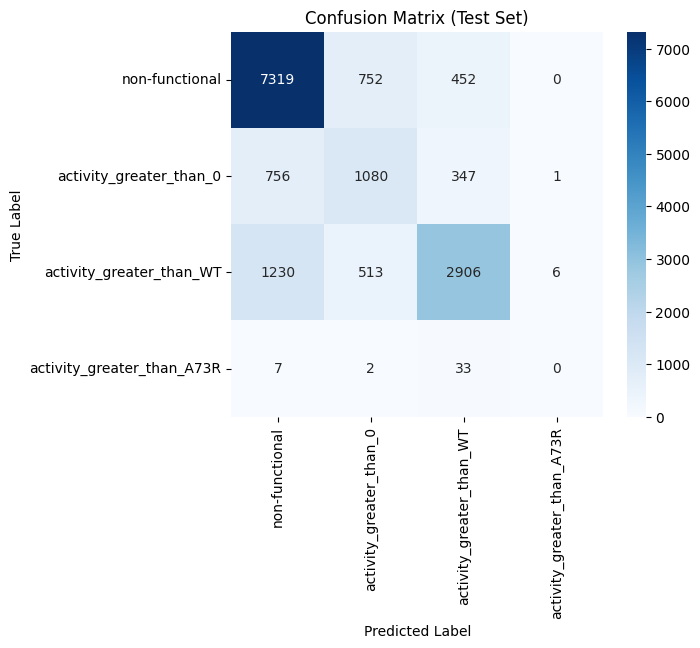

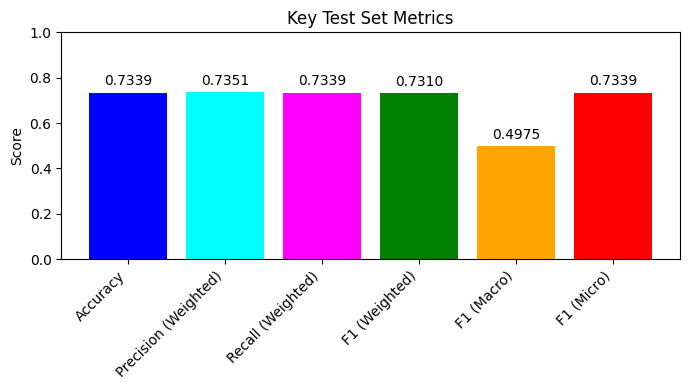

In [ ]:
# Visualise the metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if 'cm' in locals() and cm is not None:
    # Visualize the confusion matrix
    class_names = [data['label_mapping'][i] for i in range(int(data['num_classes']))]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Visualize key scalar metrics
    metrics = {
        'Accuracy': acc,
        'Precision (Weighted)': prec_w,
        'Recall (Weighted)': rec_w,
        'F1 (Weighted)': f1_w,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
    }
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    print()
    plt.figure(figsize=(7, 4))
    plt.bar(metric_names, metric_values, color=['blue', 'cyan', 'magenta', 'green', 'orange', 'red']) # Added more colors
    plt.ylabel('Score')
    plt.title('Key Test Set Metrics')
    plt.ylim(0, 1.0)
    for i, v in enumerate(metric_values):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Exercise 4

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Adam lr=0.01 | epoch 01 | val loss 1.0399
Adam lr=0.01 | epoch 02 | val loss 0.9753
Adam lr=0.01 | epoch 03 | val loss 1.2135
Adam lr=0.01 | epoch 04 | val loss 0.9174
Adam lr=0.01 | epoch 05 | val loss 0.9100
Adam lr=0.01 | epoch 06 | val loss 0.9459
Adam lr=0.01 | epoch 07 | val loss 0.9057
Adam lr=0.01 | epoch 08 | val loss 0.9230
Adam lr=0.01 | epoch 09 | val loss 6.5923
Adam lr=0.01 | epoch 10 | val loss 1.7906
Adam lr=0.01 -> final test acc: 0.3790


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Adam lr=0.001 | epoch 01 | val loss 0.8736
Adam lr=0.001 | epoch 02 | val loss 0.8108
Adam lr=0.001 | epoch 03 | val loss 0.7442
Adam lr=0.001 | epoch 04 | val loss 0.6774
Adam lr=0.001 | epoch 05 | val loss 0.6189
Adam lr=0.001 | epoch 06 | val loss 0.5699
Adam lr=0.001 | epoch 07 | val loss 0.6011
Adam lr=0.001 | epoch 08 | val loss 0.5937
Adam lr=0.001 | epoch 09 | val loss 0.5513
Adam lr=0.001 | epoch 10 | val loss 0.5798
Adam lr=0.001 -> final test acc: 0.6753


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Adam lr=0.0001 | epoch 01 | val loss 0.8953
Adam lr=0.0001 | epoch 02 | val loss 0.8464
Adam lr=0.0001 | epoch 03 | val loss 0.8704
Adam lr=0.0001 | epoch 04 | val loss 0.7970
Adam lr=0.0001 | epoch 05 | val loss 0.7036
Adam lr=0.0001 | epoch 06 | val loss 0.6300
Adam lr=0.0001 | epoch 07 | val loss 0.5994
Adam lr=0.0001 | epoch 08 | val loss 0.5631
Adam lr=0.0001 | epoch 09 | val loss 0.5883
Adam lr=0.0001 | epoch 10 | val loss 0.5977
Adam lr=0.0001 -> final test acc: 0.6727


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


SGD (m=0.9) lr=0.01 | epoch 01 | val loss 0.9158
SGD (m=0.9) lr=0.01 | epoch 02 | val loss 0.8828
SGD (m=0.9) lr=0.01 | epoch 03 | val loss 0.8385
SGD (m=0.9) lr=0.01 | epoch 04 | val loss 0.7905
SGD (m=0.9) lr=0.01 | epoch 05 | val loss 0.7757
SGD (m=0.9) lr=0.01 | epoch 06 | val loss 0.7599
SGD (m=0.9) lr=0.01 | epoch 07 | val loss 0.7461
SGD (m=0.9) lr=0.01 | epoch 08 | val loss 0.7673
SGD (m=0.9) lr=0.01 | epoch 09 | val loss 0.7442
SGD (m=0.9) lr=0.01 | epoch 10 | val loss 0.7518
SGD (m=0.9) lr=0.01 -> final test acc: 0.5607


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


SGD (m=0.9) lr=0.001 | epoch 01 | val loss 0.9050
SGD (m=0.9) lr=0.001 | epoch 02 | val loss 0.8746
SGD (m=0.9) lr=0.001 | epoch 03 | val loss 0.8986
SGD (m=0.9) lr=0.001 | epoch 04 | val loss 0.8428
SGD (m=0.9) lr=0.001 | epoch 05 | val loss 0.8749
SGD (m=0.9) lr=0.001 | epoch 06 | val loss 0.8122
SGD (m=0.9) lr=0.001 | epoch 07 | val loss 0.7946
SGD (m=0.9) lr=0.001 | epoch 08 | val loss 0.8196
SGD (m=0.9) lr=0.001 | epoch 09 | val loss 0.8222
SGD (m=0.9) lr=0.001 | epoch 10 | val loss 0.7485
SGD (m=0.9) lr=0.001 -> final test acc: 0.5058


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


SGD (m=0.9) lr=0.0001 | epoch 01 | val loss 0.9007
SGD (m=0.9) lr=0.0001 | epoch 02 | val loss 0.8951
SGD (m=0.9) lr=0.0001 | epoch 03 | val loss 1.0049
SGD (m=0.9) lr=0.0001 | epoch 04 | val loss 0.8825
SGD (m=0.9) lr=0.0001 | epoch 05 | val loss 0.8895
SGD (m=0.9) lr=0.0001 | epoch 06 | val loss 0.8723
SGD (m=0.9) lr=0.0001 | epoch 07 | val loss 0.8750
SGD (m=0.9) lr=0.0001 | epoch 08 | val loss 0.8673
SGD (m=0.9) lr=0.0001 | epoch 09 | val loss 0.9341
SGD (m=0.9) lr=0.0001 | epoch 10 | val loss 0.8964
SGD (m=0.9) lr=0.0001 -> final test acc: 0.4401


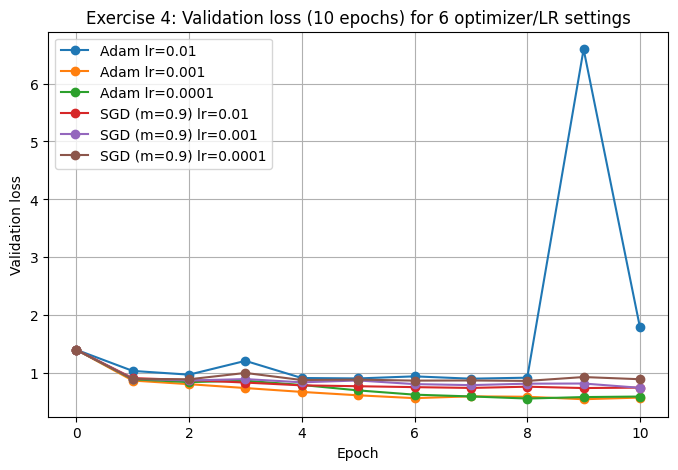

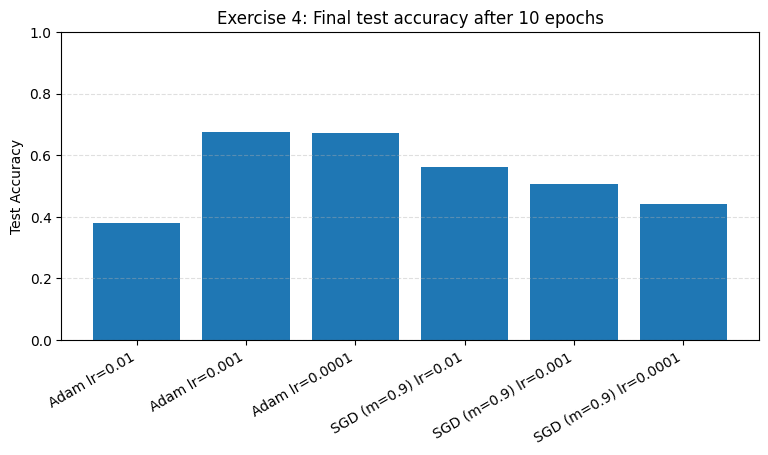

In [ ]:
# Exercise 4 (ran for 10 epochs): Adam & SGD (m=0.9) at 1e-2 / 1e-3 / 1e-4
import torch, numpy as np, random, matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import torch.nn as nn

# set seed and device
def seed_all(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
seed_all(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set dataloader
BATCH = 128
Xtr = torch.tensor(data["X_train_int"], dtype=torch.long)
ytr = torch.tensor(data["y_train"],     dtype=torch.long)
Xva = torch.tensor(data["X_val_int"],   dtype=torch.long)
yva = torch.tensor(data["y_val"],       dtype=torch.long)
Xte = torch.tensor(data["X_test_int"],  dtype=torch.long)
yte = torch.tensor(data["y_test"],      dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=BATCH, shuffle=True,  num_workers=0)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=BATCH, shuffle=False, num_workers=0)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=BATCH, shuffle=False, num_workers=0)

criterion = nn.CrossEntropyLoss()

# Set optimization alogrithm combo with learning rates
combos = [
    ("Adam",        lambda p, lr: torch.optim.Adam(p, lr=lr),              [1e-2, 1e-3, 1e-4]),
    ("SGD (m=0.9)", lambda p, lr: torch.optim.SGD(p, lr=lr, momentum=0.9), [1e-2, 1e-3, 1e-4]),
]

EPOCHS = 10

@torch.no_grad()
def val_loss(model):
    model.eval()
    tot, n = 0.0, 0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        tot += criterion(logits, yb).item() * xb.size(0)
        n   += xb.size(0)
    return tot / n

def train_n_epochs(opt_name, opt_ctor, lr, epochs=EPOCHS):

    seed_all(42)
    model = ProteinTransformerSimple(
        vocab_size=int(data["vocab_size"]),
        seq_len=int(data["sequence_length"]),
        num_classes=int(data["num_classes"]),
        d_model=256, n_layers=2, n_heads=4, d_ff=1024, dropout=0.1
    ).to(device)
    optimizer = opt_ctor(model.parameters(), lr)

    val_curve = [val_loss(model)]
    epoch_axis = [0]

    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # end-of-epoch validation
        v = val_loss(model)
        val_curve.append(v); epoch_axis.append(ep)
        print(f"{opt_name} lr={lr:g} | epoch {ep:02d} | val loss {v:.4f}")

    # final test accuracy
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xt, yt in test_loader:
            xt = xt.to(device)
            out = model(xt)
            ps.append(out.argmax(dim=-1).cpu()); ys.append(yt)
    y_true = torch.cat(ys).numpy(); y_pred = torch.cat(ps).numpy()
    test_acc = accuracy_score(y_true, y_pred)

    label = f"{opt_name} lr={lr:g}"
    print(f"{label} -> final test acc: {test_acc:.4f}")
    return epoch_axis, val_curve, test_acc, label

# run all 6 combos
all_curves = []
labels, test_accs = [], []

for name, ctor, lrs in combos:
    for lr in lrs:
        ep_x, vcurve, acc, lab = train_n_epochs(name, ctor, lr, epochs=EPOCHS)
        all_curves.append((ep_x, vcurve, lab))
        labels.append(lab); test_accs.append(acc)

# plot: validation loss curves
plt.figure(figsize=(8,5))
for xs, ys, lab in all_curves:
    plt.plot(xs, ys, marker='o', label=lab)
plt.xlabel("Epoch"); plt.ylabel("Validation loss")
plt.title("Exercise 4: Validation loss (10 epochs) for 6 optimizer/LR settings")
plt.grid(True); plt.legend(); plt.show()

# plot: bar chart of final test accuracy
plt.figure(figsize=(9,4))
x = np.arange(len(labels))
plt.bar(x, test_accs)
plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Test Accuracy"); plt.ylim(0, 1.0)
plt.title("Exercise 4: Final test accuracy after 10 epochs")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


# Exercise 5

Several models were trained and evaluated. The model loaded below, identified by its wandb artifact path, achieved the best Precision@100 score for class 3 among the models tested for this exercise.

In [ ]:
import torch, numpy as np
import wandb
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

if wandb.run is None:
    prec_at_k_run = wandb.init(
        project="protein-transformer",
        job_type="precision-at-100",
        group="Exercise5_Precision_at_100",
    )
else:
    prec_at_k_run = wandb.run

print(f"Using wandb run: {prec_at_k_run.id}")

# download artifact
artifact_path = 'ml-projects-umn/protein-transformer/final_transformer_45epochs_2e-4lr_4layers:v0'
print(f"Downloading artifact: {artifact_path}")
artifact = prec_at_k_run.use_artifact(artifact_path, type='model')
artifact_dir = artifact.download()
print(f"Artifact downloaded to: {artifact_dir}")


model = ProteinTransformerSimple(
    vocab_size=int(data["vocab_size"]),
    seq_len=int(data["sequence_length"]),
    num_classes=int(data["num_classes"]),
    d_model=256, n_layers=4, n_heads=4, d_ff=1024, dropout=0.1
).to(device)


# Find the .pt file within the downloaded artifact directory
model_path_in_artifact = None
for root, _, files in os.walk(artifact_dir):
    for file in files:
        if file.endswith('.pt'):
            model_path_in_artifact = os.path.join(root, file)
            break
    if model_path_in_artifact:
        break

if model_path_in_artifact and os.path.exists(model_path_in_artifact):
    print(f"Loading model state from: {model_path_in_artifact}")
    model.load_state_dict(torch.load(model_path_in_artifact, map_location=device))
    model.eval()

    # Prepare the test data using a DataLoader
    BATCH_SIZE = 128
    X_test_full = torch.as_tensor(data['X_test_int'], dtype=torch.long)
    y_test_full = np.asarray(data['y_test'])

    test_dataset = TensorDataset(X_test_full, torch.as_tensor(y_test_full, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Get probabilities for class 3 on the test set using the DataLoader
    all_p_class3 = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            if probs.size(1) > 3:
                p_class3_batch = probs[:, 3]
            elif probs.size(1) == 4:
                 p_class3_batch = probs[:, 3]
            else:
                print("Warning: Model output does not have enough classes to target class 3.")
                p_class3_batch = torch.zeros_like(probs[:, 0])

            all_p_class3.append(p_class3_batch.cpu())

    p_class3 = torch.cat(all_p_class3)
    k = 100
    if k > p_class3.numel():
        print(f"Warning: k ({k}) is greater than the number of samples ({p_class3.numel()}). Using all samples.")
        k = p_class3.numel()

    topk = torch.topk(p_class3, k)
    top_idx = topk.indices.detach().cpu().numpy()

    # Count how many of the top k samples are actually class 3
    hits = int((y_test_full[top_idx] == 3).sum())
    precision_at_100 = hits / k

    print(f"Precision@{k}: {precision_at_100:.4f}  |  true class-3 in top-{k}: {hits}")

    # Log Precision@100 to wandb
    if prec_at_k_run is not None:
        prec_at_k_run.log({
            "precision_at_100_class_3": precision_at_100,
            "hits_at_100_class_3": hits,
            "k_value": k,
            "artifact_evaluated": artifact_path
        })

else:
    print("Could not find the model file (.pt) in the downloaded artifact or the path is incorrect.")

# Finish the wandb run if it was initialized in this cell and is not the main run
if 'prec_at_k_run' in locals() and prec_at_k_run is not wandb.run:
    prec_at_k_run.finish()

Using wandb run: 589p6sw7


wandb:   1 of 1 files downloaded.  


Artifact downloaded to: /content/artifacts/final_transformer_45epochs_2e-4lr_4layers:v0
Loading model state from: /content/artifacts/final_transformer_45epochs_2e-4lr_4layers:v0/ex3_transformer_final_45epochs_2e-4lr_4layers.pt
Precision@100: 0.0300  |  true class-3 in top-100: 3
